In [1]:
# 示例：2012联邦选举委员会数据库
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
from matplotlib import rcParams
from matplotlib.collections import LineCollection
from pandas import DataFrame, Series

%matplotlib inline

In [2]:
fec = pd.read_csv('../data/fec/P00000001-ALL.csv', low_memory=False)
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,368633403,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,719016467,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166


In [3]:
fec.iloc[123456] # 随便抽取一条记录

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [4]:
unique_cands = fec.cand_nm.unique() # 候选人去重
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [5]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'} # 构造党派对应信息

In [6]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [7]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [8]:
fec['party'] = fec.cand_nm.map(parties) # 添加新列
fec['party'].value_counts() # 统计各个党派的数量

Democrat      593746
Republican    407985
Name: party, dtype: int64

In [9]:
(fec.contb_receipt_amt > 0).value_counts() # 出资状况统计，False表示钱又要回去的。

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [10]:
fec = fec[fec.contb_receipt_amt > 0] # 根据出资条件筛选

In [11]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])] # 再精简一下范围，只包括奥黑和罗姆尼

In [12]:
# 根据职业和雇主统计赞助信息

In [13]:
fec.contbr_occupation.value_counts()[:10] # 退休人士如此给力？

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

In [14]:
occ_mapping = {'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
               'INFORMATION REQUESTED' : 'NOT PROVIDED',
               'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
               'C.E.O.': 'CEO'} # 职业映射，便于做合并。
f = lambda x: occ_mapping.get(x, x) # get的两个参数，第一个是key，第二个是找不key到返回的默认值。
fec.contbr_occupation = fec.contbr_occupation.map(f)

In [15]:
emp_mapping = {'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
               'INFORMATION REQUESTED' : 'NOT PROVIDED',
               'SELF' : 'SELF-EMPLOYED',
               'SELF EMPLOYED' : 'SELF-EMPLOYED'} # 处理雇主信息
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [16]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party',
                                aggfunc='sum') # 根据捐款总额生成透视表
by_occupation.head()

party,Democrat,Republican
contbr_occupation,,
MIXED-MEDIA ARTIST / STORYTELLER,100.0,NaN
AREA VICE PRESIDENT,250.0,NaN
RESEARCH ASSOCIATE,100.0,NaN
TEACHER,500.0,NaN
THERAPIST,3900.0,NaN


In [17]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000] # 超过2M的狗大户，sum(1)代表沿着行的方向相加。
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


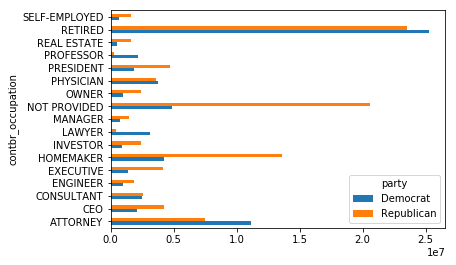

In [18]:
over_2mm.plot(kind='barh')

In [19]:
def get_top_amounts(group, key, n=5): # 分组后找key的topX条记录
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.sort_values(ascending=False)[:n] # 原来的代码[n:]不对

In [20]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7) # 根据职业

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [21]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10) # 根据雇主

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

In [22]:
# 对出资额分组

In [23]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins) # 根据捐款额划分区间
labels.head()

411      (10, 100]
412    (100, 1000]
413    (100, 1000]
414      (10, 100]
415      (10, 100]
Name: contb_receipt_amt, dtype: category
Categories (8, interval[int64]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [24]:
grouped = fec_mrbo.groupby(['cand_nm', labels]) # 根据额度分组

In [25]:
grouped.size().unstack(0) # 把外层索引变成列

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


In [26]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0) # 金额汇总
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [27]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0) # 对每一行数据归一化
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


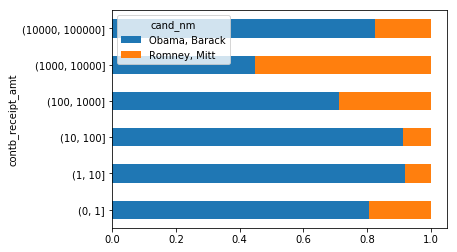

In [28]:
normed_sums[:-2].plot(kind='barh', stacked=True) # 去掉最后2行，以堆叠柱状图展现。

In [29]:
# 根据州统计赞助信息

In [30]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st']) # 根据候选人和州做分组
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0) # 各周收到的金额汇总
totals = totals[totals.sum(1) > 100000] # 金额大于10万美元的州
totals[:5]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60


In [31]:
percent = totals.div(totals.sum(1), axis=0) # 各州对候选人的捐助比例
percent.head()

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502


In [32]:
# from shapelib import ShapeFile
# import dbflib
'''
obama = percent['Obama, Barack']
fig = plt.figure(figsize=(24, 24))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
lllat = 21 # 美国的经纬度区间
urlat = 53
lllon = -118
urlon = -62
m = Basemap(ax=ax,
            projection='stere',
            lon_0=(urlon + lllon) / 2,
            lat_0=(urlat + lllat) / 2,
            llcrnrlat=lllat,
            urcrnrlat=urlat,
            llcrnrlon=lllon,
            urcrnrlon=urlon,
            resolution='l')
m.drawcoastlines() # 海岸线
m.drawcountries() # 国境线
shp = ShapeFile('../data/fec/states/statesp020')
dbf = dbflib.open('../data/fec/states/statesp020')
for npoly in range(shp.info()[0]):
    # 在地图上绘制彩色多边形
    shpsegs = []
    shp_object = shp.read_object(npoly)
    verts = shp_object.vertices()
    rings = len(verts)
    for ring in range(rings):
        lons, lats = zip(*verts[ring])
        x, y = m(lons, lats)
        shpsegs.append(zip(x,y))
    if ring == 0:
        shapedict = dbf.read_record(npoly)
        name = shapedict['STATE']
        name = 'Texas'
        lines = LineCollection(shpsegs,antialiaseds=(1,))
        # state_to_code字典，例如'ALASKA' -> 'AK', omitted
        try:
            per = obama[state_to_code[name.upper()]]
        except KeyError:
            continue
        lines.set_facecolors('k')
        lines.set_alpha(0.75 * per) # 把“百分比”变小一点
        lines.set_edgecolors('k')
        lines.set_linewidth(0.3)
'''
pass
# TODO: 这块以后再搞吧。。。太TM扯了，ShapeFile和dbflib的安装配置搞不定，数据格式待破解。
# 目前尝试了使用以下代码加载数据文件：
# import shapefile
# shp = shapefile.Reader('../data/fec/states/statesp020')
# for shape in shp.shapes():
#     不知道该怎么利用shape.points去画图，另外该怎么匹配州的信息？
#     代码是利用每个州的比例设置alpha值。